# Model: necks

"A neck can be utilized to aggregate features for enlarging receptive field and fusing multi-scale context" ([https://arxiv.org/abs/2305.04925](https://arxiv.org/abs/2305.04925)).

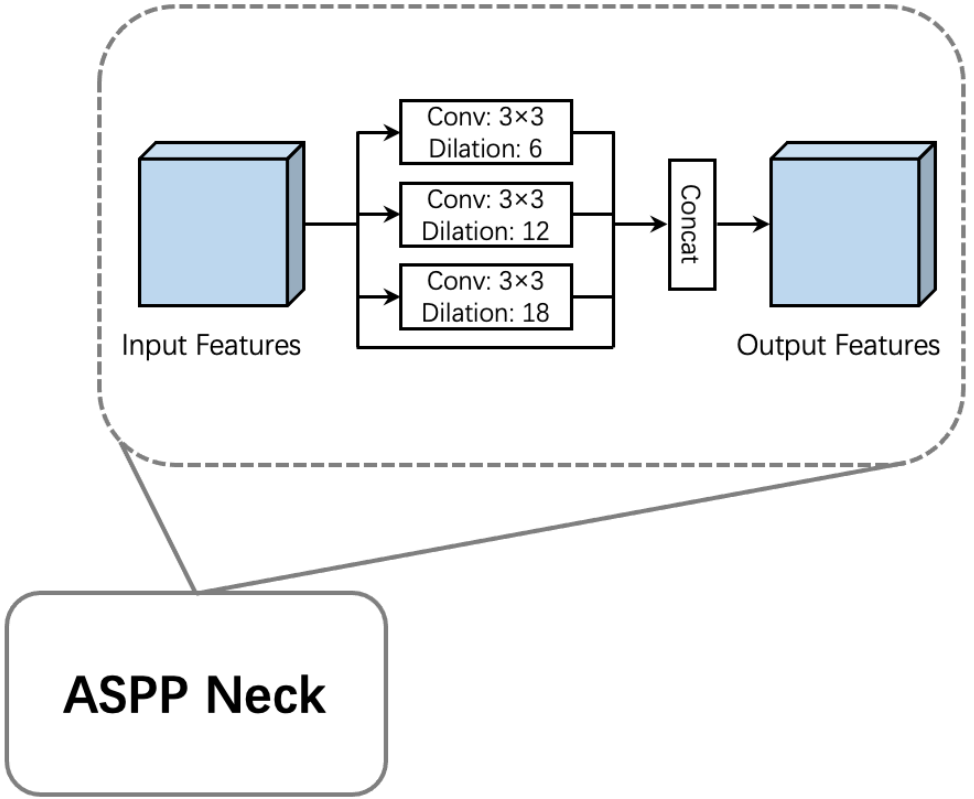

In [ ]:
#| default_exp models/model_necks

In [ ]:
#|export
import torch
import torch.nn as nn
from pillarnext_explained.models.model_utils import BasicBlock, ConvBlock
import torch.utils.checkpoint as cp
import torch.nn.functional as F

In [ ]:
#|exports
class ASPPNeck(nn.Module):
    """
    Atrous Spatial Pyramid Pooling Neck Module.

    This module applies several convolutions with different dilation rates
    to the input feature map and concatenates their outputs. The concatenated
    output is then passed through a convolutional block to produce the final output.
    """
    def __init__(self,
                 in_channels: int # Number of input channels
                 ):

        super(ASPPNeck, self).__init__()

        self.pre_conv = BasicBlock(in_channels)
        self.conv1x1 = nn.Conv2d(
            in_channels, in_channels, kernel_size=1, stride=1, bias=False, padding=0)
        self.weight = nn.Parameter(torch.randn(in_channels, in_channels, 3, 3))
        self.post_conv = ConvBlock(in_channels * 6, in_channels, kernel_size=1, stride=1)

    def _forward(self, x):
        x = self.pre_conv(x)
        branch1x1 = self.conv1x1(x)
        branch1 = F.conv2d(x, self.weight, stride=1,
                           bias=None, padding=1, dilation=1)
        branch6 = F.conv2d(x, self.weight, stride=1,
                           bias=None, padding=6, dilation=6)
        branch12 = F.conv2d(x, self.weight, stride=1,
                            bias=None, padding=12, dilation=12)
        branch18 = F.conv2d(x, self.weight, stride=1,
                            bias=None, padding=18, dilation=18)
        x = self.post_conv(
            torch.cat((x, branch1x1, branch1, branch6, branch12, branch18), dim=1))
        return x

    def forward(self, x):
        if x.requires_grad:
            out = cp.checkpoint(self._forward, x)
        else:
            out = self._forward(x)

        return out

The `ASPPNeck` class is an implementation of the Atrous Spatial Pyramid Pooling (ASPP) module, which is a technique commonly used in computer vision, particularly in segmentation tasks, to effectively capture multi-scale contextual information. In the context of the framework, this module is applied within a 3D object detection framework to enhance the model's ability to detect objects in the pointclouds.

By integrating the ASPP module, the architecture can effectively aggregate multi-scale contextual information, enhancing the model's ability to detect objects at different scales and distances. The neck component in such architectures aggregates features from the backbone, thereby enhancing the receptive field and fusing multi-scale context.

#### Implementation Details

- **Pre-Processing Block (`pre_conv`)**: The module begins with a `BasicBlock` that processes the input feature map. This step likely refines the features and prepares them for further processing by the ASPP layers.
  
- **1x1 Convolution (`conv1x1`)**: A 1x1 convolution is applied to the input, producing a branch with the same number of channels as the input. This is part of the multi-branch strategy that ASPP employs to capture features at different scales.

- **Dilated Convolutions**: The heart of ASPP lies in applying convolutions with different dilation rates (1, 6, 12, and 18). These convolutions capture features at multiple scales, with larger dilation rates corresponding to larger receptive fields. This multi-scale approach allows the model to better capture objects of varying sizes and distances in point clouds.

    - The authors decided to use fixed and manually chosen dilation rates, which might not be optimal for all datasets or detection tasks.

- **Feature Concatenation**: The outputs of these dilated convolutions, along with the original input and the 1x1 convolution output, are concatenated along the channel dimension. This results in a feature map that contains information from multiple scales, which is then further processed.

- **Post-Processing Block (`post_conv`)**: After concatenation, a `ConvBlock` is applied to the combined features to produce the final output. This step integrates the multi-scale features and prepares them for subsequent stages in the detection pipeline.

- **Checkpointing**: The module includes a checkpointing mechanism to save memory during backpropagation, which is especially important when training deep networks on large datasets like LiDAR pointclouds.

In [ ]:
#|eval: false
# Create a sample input tensor with batch size 1, 64 channels, and 128x128 spatial dimensions
input_tensor = torch.randn(1, 64, 128, 128)

# Initialize the ASPPNeck module with 64 input channels
aspp_neck = ASPPNeck(64)

# Pass the input tensor through the ASPPNeck module
output_tensor = aspp_neck(input_tensor)

# Print the shape of the output tensor
print("Output shape:", output_tensor.shape)

Output shape: torch.Size([1, 64, 128, 128])
